# Stanford RNA 3D Folding Competition Notebook
1. Data Exploration  
2. Data Preprocessing  
   - Sequence encoding  
   - Label grouping and padding (with NaN handling)
3. Model Building using a fast CNN architecture  
4. Model Training with early stopping  
5. Prediction on test set and submission file generation

_Note: This notebook uses only the provided CSV files (no external internet access)._

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras for deep learning model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading and Exploration

We load the CSV files provided:
- `train_sequences.csv`
- `train_labels.csv`
- `validation_sequences.csv` & `validation_labels.csv`
- `test_sequences.csv`
- `sample_submission.csv`

**Important:** We fill missing values in the labels data with 0 to avoid NaN issues during training.

In [2]:
# Define file paths (Kaggle input paths)
TRAIN_SEQ_PATH = '/kaggle/input/stanford-rna-3d-folding/train_sequences.csv'
TRAIN_LABELS_PATH = '/kaggle/input/stanford-rna-3d-folding/train_labels.csv'
VALID_SEQ_PATH = '/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv'
VALID_LABELS_PATH = '/kaggle/input/stanford-rna-3d-folding/validation_labels.csv'
TEST_SEQ_PATH  = '/kaggle/input/stanford-rna-3d-folding/test_sequences.csv'
SAMPLE_SUB_PATH = '/kaggle/input/stanford-rna-3d-folding/sample_submission.csv'

# Load CSV files
train_sequences = pd.read_csv(TRAIN_SEQ_PATH)
train_labels = pd.read_csv(TRAIN_LABELS_PATH)
valid_sequences = pd.read_csv(VALID_SEQ_PATH)
valid_labels = pd.read_csv(VALID_LABELS_PATH)
test_sequences = pd.read_csv(TEST_SEQ_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

# Fill missing values in labels with 0
train_labels.fillna(0, inplace=True)
valid_labels.fillna(0, inplace=True)

# Display basic info
print("Train Sequences Shape:", train_sequences.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Sequences Shape:", valid_sequences.shape)
print("Validation Labels Shape:", valid_labels.shape)
print("Test Sequences Shape:", test_sequences.shape)

# Look at a few examples
print("\nTrain Sequences Head:")
print(train_sequences.head())
print("\nTrain Labels Head:")
print(train_labels.head())

Train Sequences Shape: (844, 5)
Train Labels Shape: (137095, 6)
Validation Sequences Shape: (12, 5)
Validation Labels Shape: (2515, 123)
Test Sequences Shape: (12, 5)

Train Sequences Head:
  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chai

## 3. Data Preprocessing

### 3.1 Sequence Encoding

We map each nucleotide to an integer:
- A: 1, C: 2, G: 3, U: 4  
Unknown characters are mapped to 0.

In [3]:
nucleotide_map = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def encode_sequence(seq):
    """Encodes a RNA sequence into a list of integers based on nucleotide_map."""
    return [nucleotide_map.get(ch, 0) for ch in seq]

# Apply encoding to all sequence files
train_sequences['encoded'] = train_sequences['sequence'].apply(encode_sequence)
valid_sequences['encoded'] = valid_sequences['sequence'].apply(encode_sequence)
test_sequences['encoded'] = test_sequences['sequence'].apply(encode_sequence)

### 3.2 Processing Label Data

Each row in the labels CSV is for one residue, with an `ID` formatted as `target_id_resid`.
We group rows by `target_id` and sort by residue number.
Here, we use the first structure (x_1, y_1, z_1) as our target coordinates.

In [4]:
def process_labels(labels_df):
    """
    Processes a labels DataFrame by grouping rows by target_id.
    Returns a dictionary mapping target_id to an array of coordinates (seq_len, 3).
    """
    label_dict = {}
    for idx, row in labels_df.iterrows():
        # Split ID into target_id and residue number (assumes format "targetid_resid")
        parts = row['ID'].split('_')
        target_id = "_".join(parts[:-1])
        resid = int(parts[-1])
        # Extract the coordinates; they should be numeric (missing values already set to 0)
        coord = np.array([row['x_1'], row['y_1'], row['z_1']], dtype=np.float32)
        if target_id not in label_dict:
            label_dict[target_id] = []
        label_dict[target_id].append((resid, coord))
    
    # Sort residues by resid and stack coordinates
    for key in label_dict:
        sorted_coords = sorted(label_dict[key], key=lambda x: x[0])
        coords = np.stack([c for r, c in sorted_coords])
        label_dict[key] = coords
    return label_dict

# Process training and validation labels
train_labels_dict = process_labels(train_labels)
valid_labels_dict = process_labels(valid_labels)

### 3.3 Creating Datasets and Padding

We match each target sequence with its corresponding coordinate labels.
Then we pad sequences and coordinate arrays to a uniform length.

Padded positions in coordinates are set to 0.

In [5]:
def create_dataset(sequences_df, labels_dict):
    """
    Creates a dataset from a sequences DataFrame and a labels dictionary.
    Returns:
        X: list of encoded sequences,
        y: list of coordinate arrays,
        target_ids: list of target ids.
    """
    X, y, target_ids = [], [], []
    for idx, row in sequences_df.iterrows():
        tid = row['target_id']
        if tid in labels_dict:
            X.append(row['encoded'])
            y.append(labels_dict[tid])
            target_ids.append(tid)
    return X, y, target_ids

# Create training and validation datasets
X_train, y_train, train_ids = create_dataset(train_sequences, train_labels_dict)
X_valid, y_valid, valid_ids = create_dataset(valid_sequences, valid_labels_dict)

# Determine maximum sequence length from training set
max_len = max(len(seq) for seq in X_train)
print("Maximum sequence length (train):", max_len)

# Pad the sequences (padding value = 0)
X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_valid_pad = pad_sequences(X_valid, maxlen=max_len, padding='post', value=0)

# Function to pad coordinate arrays
def pad_coordinates(coord_array, max_len):
    L = coord_array.shape[0]
    if L < max_len:
        pad_width = ((0, max_len - L), (0, 0))
        return np.pad(coord_array, pad_width, mode='constant', constant_values=0)
    else:
        return coord_array

# Pad coordinate arrays
y_train_pad = np.array([pad_coordinates(arr, max_len) for arr in y_train])
y_valid_pad = np.array([pad_coordinates(arr, max_len) for arr in y_valid])

# Check for any NaN values in the targets
print("Any NaN in y_train_pad?", np.isnan(y_train_pad).any())
print("Any NaN in y_valid_pad?", np.isnan(y_valid_pad).any())

print("X_train_pad shape:", X_train_pad.shape)
print("y_train_pad shape:", y_train_pad.shape)

Maximum sequence length (train): 4298
Any NaN in y_train_pad? False
Any NaN in y_valid_pad? False
X_train_pad shape: (844, 4298)
y_train_pad shape: (844, 4298, 3)


## 4. Fast CNN Model Training

In this section, we build a faster CNN-based model.
The model uses:
- An Embedding layer  
- Two Conv1D blocks (with BatchNormalization and Dropout)  
- A final Conv1D layer (kernel size 1) to output 3 coordinates per residue

In [6]:
# Define hyperparameters for the CNN model
vocab_size = max(nucleotide_map.values()) + 1  # +1 for padding token 0
embedding_dim = 16
num_filters = 64
kernel_size = 3
drop_rate = 0.2

# Build the CNN model
input_seq_cnn = Input(shape=(max_len,), name='input_seq')
x_cnn = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embedding')(input_seq_cnn)

# First convolutional block
x_cnn = Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu', name='conv1')(x_cnn)
x_cnn = BatchNormalization(name='bn1')(x_cnn)
x_cnn = Dropout(drop_rate, name='drop1')(x_cnn)

# Second convolutional block
x_cnn = Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu', name='conv2')(x_cnn)
x_cnn = BatchNormalization(name='bn2')(x_cnn)
x_cnn = Dropout(drop_rate, name='drop2')(x_cnn)

# Final convolution to output 3 coordinates per residue (x, y, z)
output_coords_cnn = Conv1D(filters=3, kernel_size=1, padding='same', activation='linear', name='predicted_coords')(x_cnn)

cnn_model = Model(inputs=input_seq_cnn, outputs=output_coords_cnn)
cnn_model.compile(optimizer='adam', loss='mse')

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_seq (InputLayer)               │ (None, 4298)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 4298, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 4298, 64)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 4298, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop1 (Dropout)                      │ (None, 4298, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 4298, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 4298, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 4298, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predicted_coords (Conv1D)            │ (None, 4298, 3)             │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,275 (63.57 KB)

 Trainable params: 16,019 (62.57 KB)

 Non-trainable params: 256 (1.00 KB)

## 5. Model Training

We train the CNN model using early stopping to monitor the validation loss.
With the NaN issues addressed in the data, training should proceed without nan losses.

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 708.7315 - val_loss: 290832909220992902620675565420544.0000
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 664.9088 - val_loss: 290832909220992902620675565420544.0000
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 646.5882 - val_loss: 290832909220992902620675565420544.0000
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 636.8010 - val_loss: 290832909220992902620675565420544.0000
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 632.7646 - val_loss: 290832909220992902620675565420544.0000
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 630.8857 - val_loss: 290832909220992902620675565420544.0000


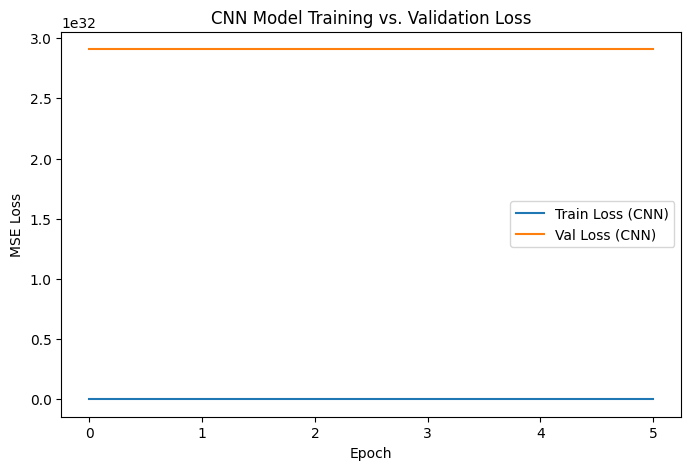

In [7]:
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_pad, y_train_pad,
                            validation_data=(X_valid_pad, y_valid_pad),
                            epochs=50,
                            batch_size=16,
                            callbacks=[early_stop_cnn],
                            verbose=1)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_cnn.history['loss'], label='Train Loss (CNN)')
plt.plot(history_cnn.history['val_loss'], label='Val Loss (CNN)')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN Model Training vs. Validation Loss")
plt.legend()
plt.show()

## 6. Generating Predictions and Submission File

For each test sequence, we predict the 3D coordinates using our trained CNN model.

The submission requires 5 sets of coordinates per target. In this baseline, we replicate the same predicted structure 5 times.

In [8]:
# Prepare test data: pad sequences to same length as training
X_test = test_sequences['encoded'].tolist()
X_test_pad = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

# Predict coordinates using the trained CNN model
predictions = cnn_model.predict(X_test_pad)

# Build submission rows. Each row corresponds to a residue from a test target.
submission_rows = []
for idx, row in test_sequences.iterrows():
    target_id = row['target_id']
    # Get predicted coordinates (shape: [max_len, 3])
    pred_coords = predictions[idx]
    # Determine actual sequence length
    seq_length = len(row['encoded'])
    pred_coords = pred_coords[:seq_length, :]  # only actual residues
    
    # For each residue, create a row in the submission file
    for i in range(seq_length):
        coords = pred_coords[i, :]
        # Replicate the same prediction 5 times for submission format
        submission_rows.append({
            'ID': f"{target_id}_{i+1}",
            'resname': row['sequence'][i],
            'resid': i+1,
            **{f"x_{j+1}": coords[0] for j in range(5)},
            **{f"y_{j+1}": coords[1] for j in range(5)},
            **{f"z_{j+1}": coords[2] for j in range(5)}
        })

submission_df = pd.DataFrame(submission_rows)
print("Submission DataFrame shape:", submission_df.shape)
print(submission_df.head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Submission DataFrame shape: (2515, 18)
         ID resname  resid       x_1       x_2       x_3       x_4       x_5  \
0   R1107_1       G      1  1.173633  1.173633  1.173633  1.173633  1.173633   
1   R1107_2       G      2  1.634578  1.634578  1.634578  1.634578  1.634578   
2   R1107_3       G      3  1.719558  1.719558  1.719558  1.719558  1.719558   
3   R1107_4       G      4  1.713900  1.713900  1.713900  1.713900  1.713900   
4   R1107_5       G      5  1.690360  1.690360  1.690360  1.690360  1.690360   
5   R1107_6       C      6  1.696408  1.696408  1.696408  1.696408  1.696408   
6   R1107_7       C      7  1.729560  1.729560  1.729560  1.729560  1.729560   
7   R1107_8       A      8  1.807830  1.807830  1.807830  1.807830  1.807830   
8   R1107_9       C      9  1.808475  1.808475  1.808475  1.808475  1.808475   
9  R1107_10       A     10  1.855314  1.855314  1.855314  1.855314  1.855314   

        y_1       y_2       y_3       y_4

## 7. Saving the Submission File

Finally, we save the submission file as `submission.csv`.

In [9]:
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
